In [1]:
# EEG pre-processing using MNI Python
# Experimental Lab course
# created by Shiri Makov, April 2022

import os
import mne
import numpy as np
import matplotlib.pyplot as plt

# fix matplotlib backend to allow interacctive plotting
%matplotlib notebook 

data_path = 'C:/Users/mkshi/Documents/GitHub/EEG-preprocessing-pipeline'

# Read EEG data

In [2]:
subject_name = input('This tutorial defaultly loads the an example data file. In case you want to load another file, please enter subject file name. Otherwise, press Enter')
if not(subject_name):
    subject_name = 'Example_data'
data_fname = os.path.join(data_path,subject_name)+'.edf'
raw = mne.io.read_raw_edf(data_fname, preload=True)
raw.filter(1,30)
raw.pick(['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4','MARKER'])  # change according to the channels in your recording system
raw.set_channel_types({'MARKER':'stim'})
sampling_freq = raw.info['sfreq']
data_len = len(raw.times)
# make a montage for later plots of the electrodes 2D layout
emotiv_montage = mne.channels.make_standard_montage('standard_1020')
raw.info.set_montage(emotiv_montage)
print(raw.info.get_montage)

This tutorial defaultly loads the an example data file. In case you want to load another file, please enter subject file name. Otherwise, press Enter
Extracting EDF parameters from C:\Users\mkshi\Documents\GitHub\EEG-preprocessing-pipeline\Example_data.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 39423  =      0.000 ...   307.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 sec)

<bound method MontageMixin.get_montage 

<ipython-input-2-c62a9dde7b5e>:8: RuntimeWarning: The unit for channel(s) MARKER has changed from V to NA.
  raw.set_channel_types({'MARKER':'stim'})


# Check triggers timing (not mandatory)

<IPython.core.display.Javascript object>


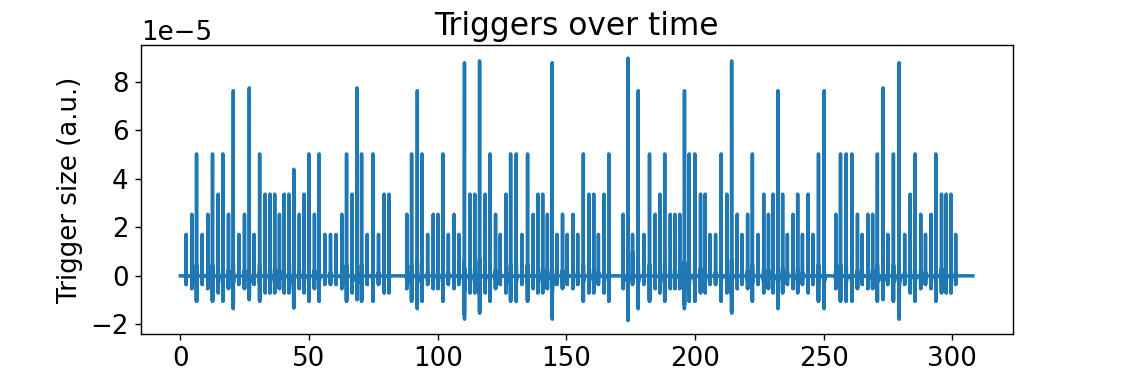

In [3]:
trigger_channel_index = raw.info['ch_names'].index('MARKER')
raw_selection = raw[trigger_channel_index, 0:len(raw.times)]
times_vector = raw_selection[1]
triggers_vector = raw_selection[0].T
plt.figure(figsize=(9,3))
plt.rcParams.update({'font.size': 15})
plt.title('Triggers over time')
plt.rcParams.update({'font.size': 10})
plt.xlabel('Time (sec)')
plt.ylabel('Trigger size (a.u.)')
plt.plot(times_vector,triggers_vector, linewidth=2)
plt.show()
plt.rcParams.update({'font.size': 9}) # return to smaller font

# Mark big artifacts manually

###### Note for users: Pressing on a channel marks it as 'bad'. Use the Help button to learn more about GUI toggling options.

Using matplotlib as 2D backend.
Opening raw-browser...


<IPython.core.display.Javascript object>


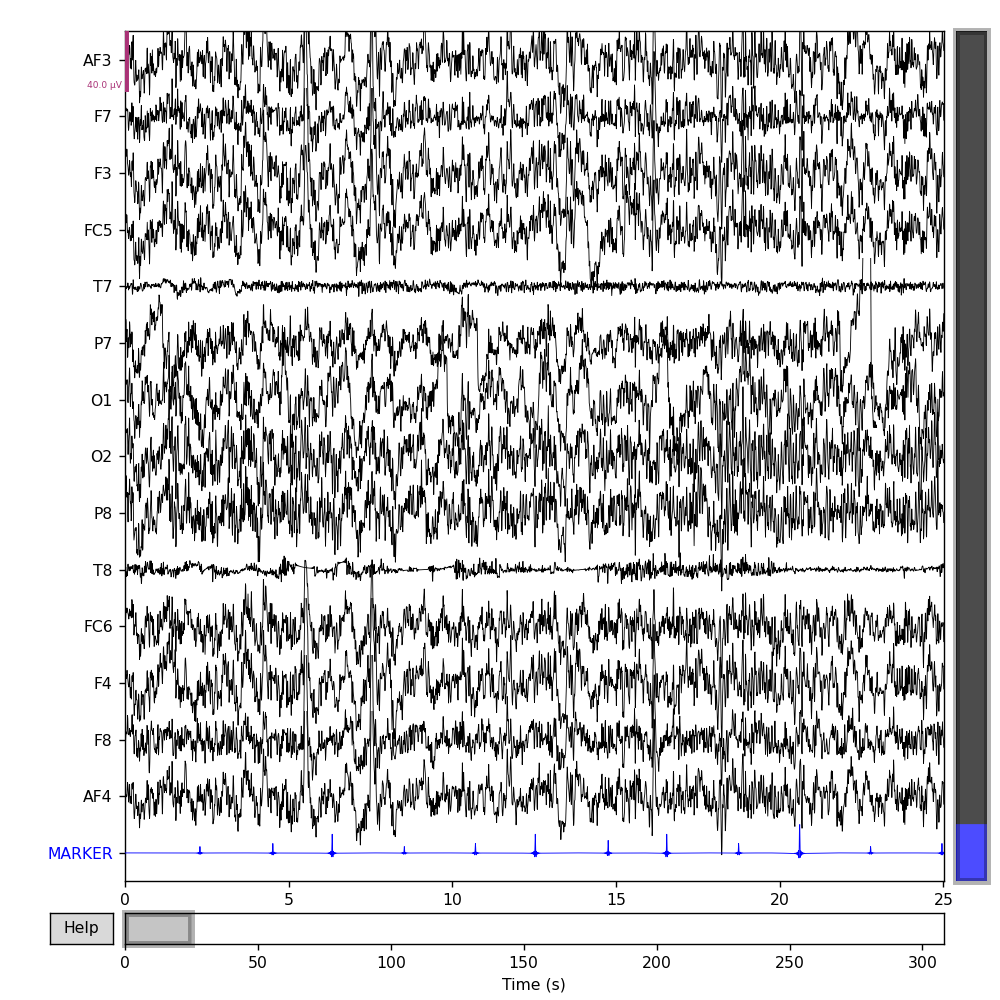

<IPython.core.display.Javascript object>


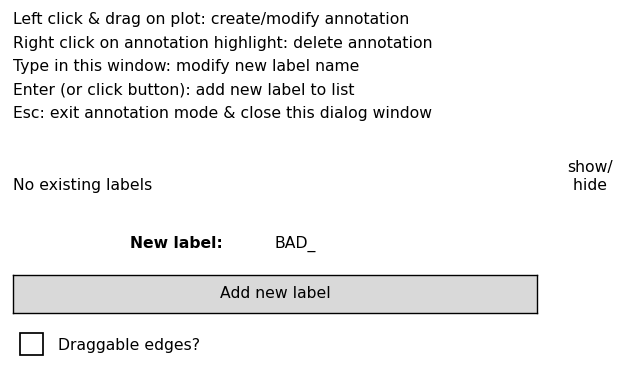

In [4]:
fig = raw.plot(duration=25, color={'eeg':'k','stim':'b'})
fig.fake_keypress('a') # allow annotation mode in advance

# Use ICA to isolate eye-blink and heart-beat componenets

In [5]:
method = 'infomax' # since sources are not completely independent, see doi:10.1109/TSP.2018.2844203 for more information.
n_components = 8 # We should expect the eye-blinks and heart-beat components to be at the top
random_state = 1 # in order to have similar decomposition and similar order of components in this tutorial, despite the fact that ICA is a non-deterministic algorithm
ica = mne.preprocessing.ICA(n_components=n_components, random_state=random_state, max_iter='auto')

electrodes = mne.pick_types(raw.info, eeg=True)
ica.fit(raw, picks=electrodes) # perform only on the EEG channels (not the triggers channel)

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.3s.


Method,fastica
Fit,26 iterations on raw data (39424 samples)
ICA components,8
Explained variance,98.6 %
Available PCA components,14
Channel types,eeg
ICA components marked for exclusion,—


### Inspect at the time-course and 2D topography of ICA components. Manually mark components you would like to remove by pressing their time-course at the top figure

Creating RawArray with float64 data, n_channels=8, n_times=39424
    Range : 0 ... 39423 =      0.000 ...   307.992 secs
Ready.
Opening ica-browser...


<IPython.core.display.Javascript object>


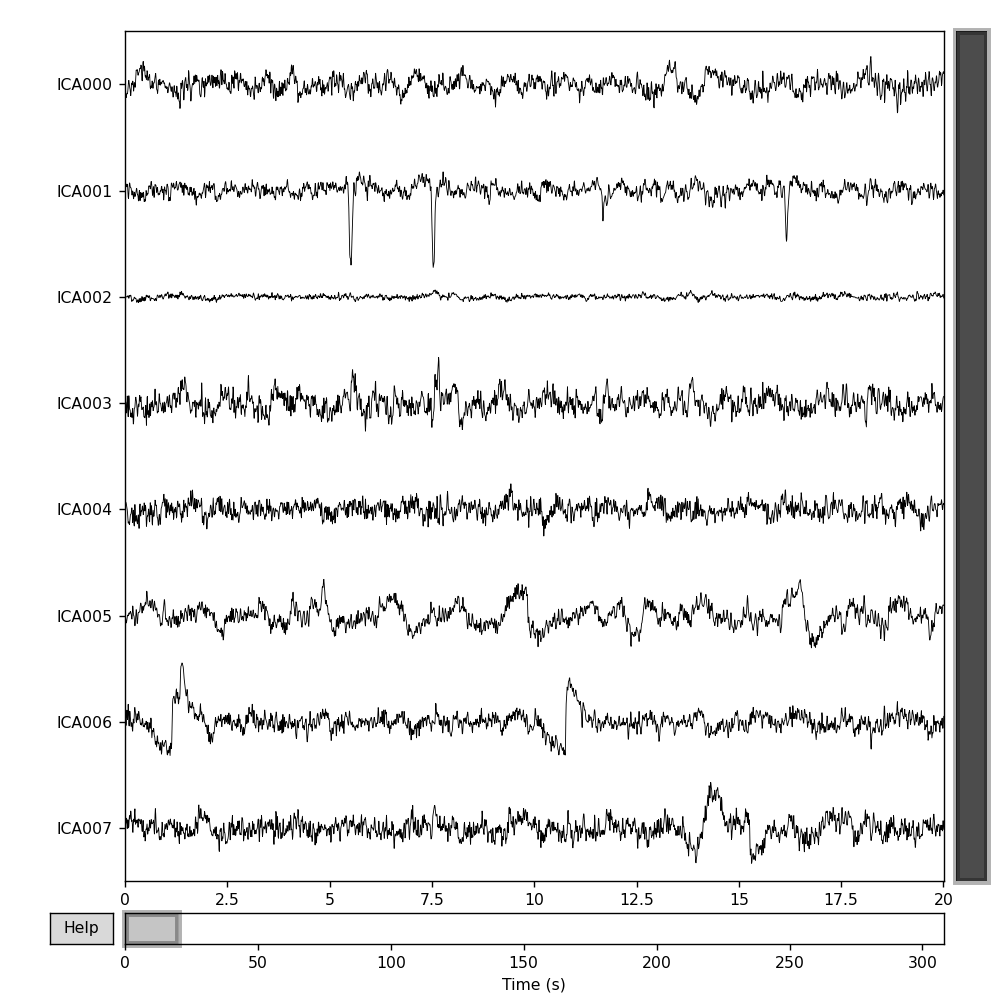

<IPython.core.display.Javascript object>


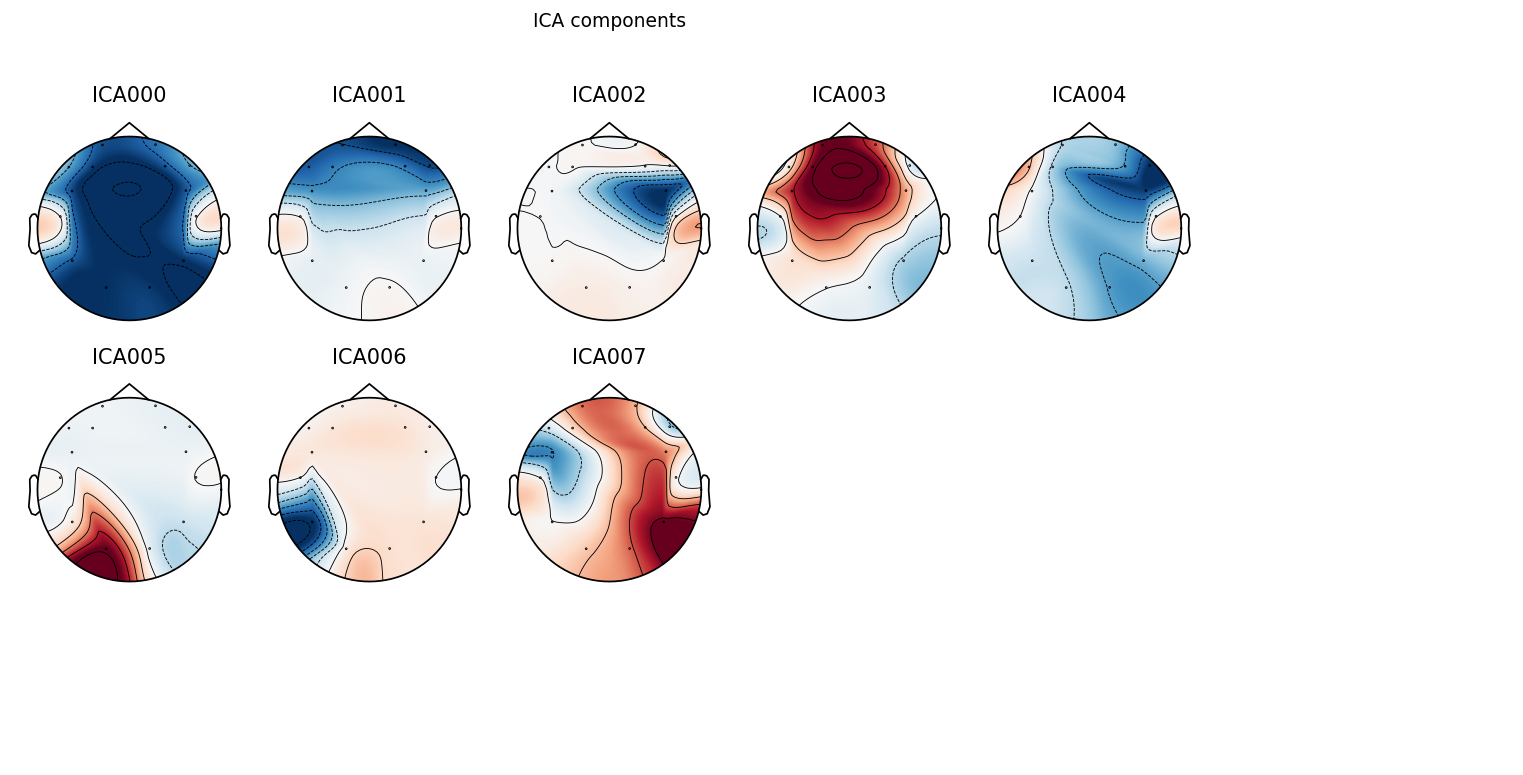

[<MNEFigure size 975x496 with 8 Axes>]

In [6]:
ica.plot_sources(raw, picks=None)
ica.plot_components()

##### In the above example, when using the example data file, the eye-blinks component is #1

In [7]:
component_ind_to_reject = list(input("Enter which components you would like to reject: "))
for i in range(len(component_ind_to_reject)):
    component_ind_to_reject[i] = int(component_ind_to_reject[i])

ica.exclude = component_ind_to_reject
cleanData=ica.apply(raw) # signal reconstruction

Enter which components you would like to reject: 1
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components


# Review the clean data after rejecting eye-blinks and heart-beat signals

Opening raw-browser...


<IPython.core.display.Javascript object>


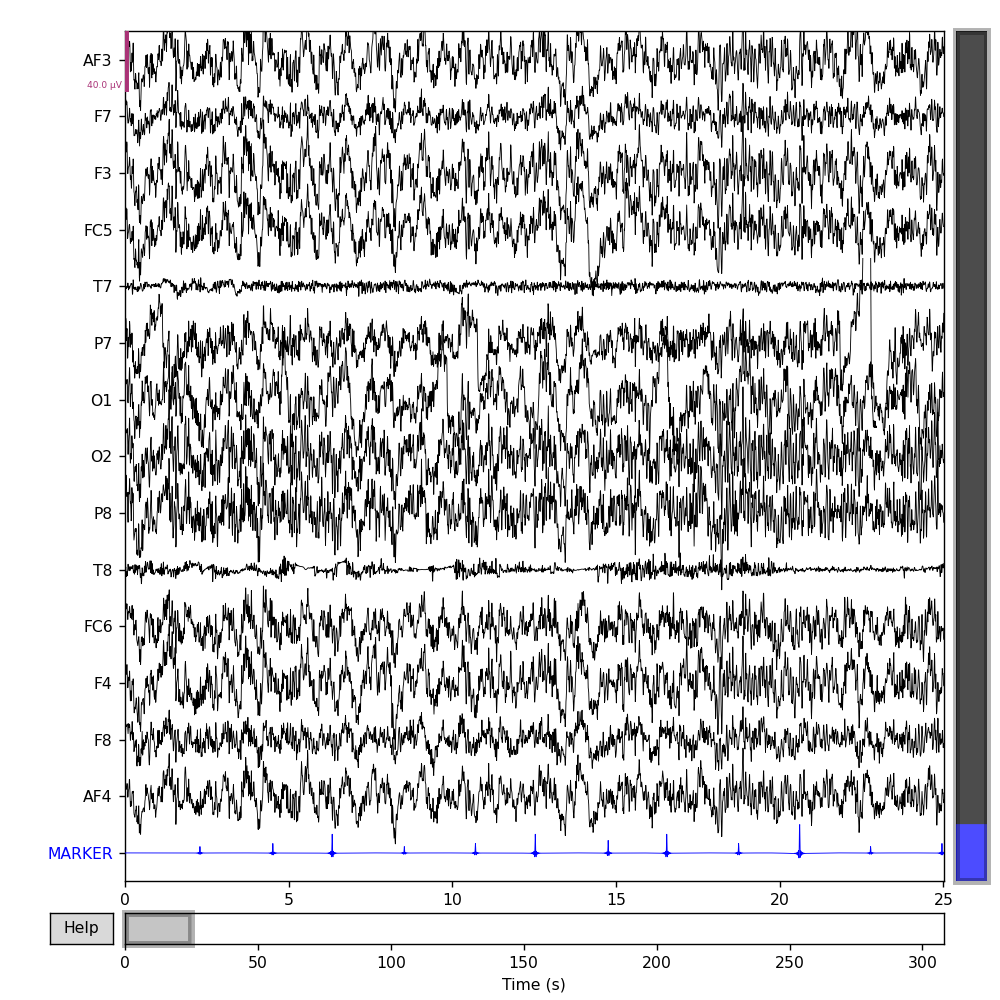

<IPython.core.display.Javascript object>


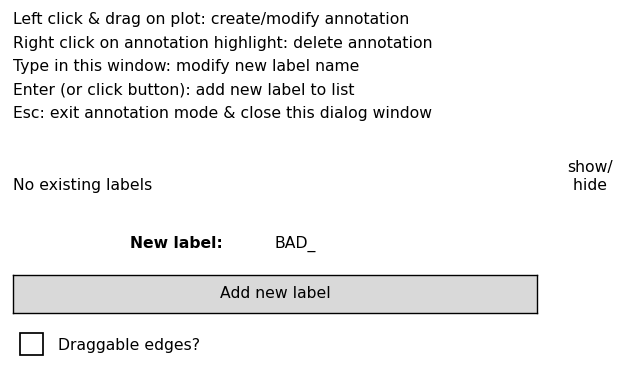

In [8]:
fig = cleanData.plot(duration=25, color={'eeg':'k','stim':'b'})
fig.fake_keypress('a') # allow annotation mode

# Save file

In [9]:
saving_fname = os.path.join(data_path,subject_name + '_cleanData_eeg.fif')
cleanData.save(saving_fname, overwrite=True)

Overwriting existing file.
Writing C:\Users\mkshi\Documents\GitHub\EEG-preprocessing-pipeline\Example_data_cleanData_eeg.fif
Closing C:\Users\mkshi\Documents\GitHub\EEG-preprocessing-pipeline\Example_data_cleanData_eeg.fif
[done]
